In [1]:
import os
os.getcwd()
os.chdir(r"C:\Users\karli\OneDrive\Documenten\School\TU Eindhoven\Programmas\Github\8DC00_MIA\8DC00_MIA\code")

# Topic 1.2: Point-based registration

This notebook combines theory with exercises to support the understanding of point-based registration in medical image analysis. Implement all functions in the `code` folder of your cloned repository, and test it in this notebook after implementation by importing your functions to this notebook. Use available markdown sections to fill in your answers to questions as you proceed through the notebook.

**Contents:** <br>

1. [Point-based registration (theory)](#pb_reg_theory)<br>

   - [Optimization](#optimization)<br>
   - [Evaluation of image registration accuracy](#evaluation)<br>
    
    
2. [Point-based transformations (theory and exercises)](#ls)<br>

    2.1 [Inverse mapping](#ls_inv_map)<br>
    
    2.2 [Least squares solution to an overdetermined system of linear equations](#ls_overdet_sys_lin_eq)<br>
    
    2.3 [Least squares fitting of an affine transformation](#ls_affine)<br>
    
**References:**<br>

[1] Point-based registration: [Fitzpatrick, J.M., et al. Image registration, chapter 8.3](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.5408&rep=rep1&type=pdf)

In [2]:
%load_ext autoreload
%autoreload 2

<div id='pb_reg_theory'></div>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

## 1. Point-based registration (theory)

Image registration driven by a reliable (set of) reference point(s) on both the fixed and moving views is referred to as point-based ([Fitzpatrick, J.M., et al. Image registration, chapter 8.3](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.5408&rep=rep1&type=pdf)). Selected points in the fixed image that are considered reliable, and are typically called _fiducial points_ or _fiducials_, can be part of two groups of distinguishable features: _intrinsic features_ (anatomical landmarks, such as the intersection of the central sulcus with the midline of the brain), or _extrinsic features_ (implanted markers, e.g. on a head coil). 

Unlike in landmark-based registration, marker-based registration tends to be more precise due to its independence of anatomical structures which may sometimes be hard to discern. Fiducial points within markers may be produced via automated methods that typically assign location to the centroid of the marker. 

A perfect fiducial alignment is typically impossible due to multiple reasons. There is always some fiducial localization error of the marker, and misalignments, shifts or distortions of the markers may occur relative to the voxel grid. The aim of fiducial-guided registration is to minimize the variance in the two views. Generally, the effective mean displacement will be smaller in magnitude if the marker is larger (ideally beyond the voxel size) and vice versa. Larger markers spanning more than two voxels can be more accurately localized, thereby improving the registration outcome. Reasons are three-fold:

1. When the marker is large, the fraction of partially filled voxels within it is lower
2. Erroneous shifts are cancelled out when the marker partially fills more voxels
3. Noise averaging over a larger number of voxels

Example: Assuming two images misaligned by translation, a simple registration algorithm that is efficient in this example would consist of these steps:

- Mark the location of some well discernible features in the fixed image
- Mark the corresponding location in the moving image
- Compute the translation as $t = x^{\prime} - x$
- Transform the moving image by translating it with $\mathbf{-t}$
 
It is therefore unrealistic to look for an algorithm that will find a transformation that results in a perfect alignment of all corresponding fiducial pairs. However, we can design an algorithm that will find a transformation that results in the best possible alignment given that fact that there will always be some error. The better an algorithm aligns the two views, the lower this error becomes. 

How to find the transformation that aligns fiducials at the lowest possible alignment error?

- Step 1: Write the error as a function of the transformation (affine registration)
- Step 2: Find the minimum of the error function w.r.t. the transformation 

<div id="optimization"></div>

### Optimization
Optimization involves finding the best parameters according to an objective function, which is either minimised or maximised. If we have a method that finds the maximum of a function, it can be easily used to find a minimum by inverting the function. 


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div> 

### *Question 1.1*:
Why is full search of the parameter space not the most efficient optimization approach in 2D? Ideally, explain by example.

<font style="color:red">Since we are looking for the smallest error possible, we for sure are looking for a local minimum</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div> 

### *Question 1.2*:
What would be a better solution?

<font style="color:red">Look for the minima and maxima in the graph of optimization</font>

<div id="evaluation"></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

### Evaluation of image registration accuracy
Image registration can be evaluated by computing the registration error for some target corresponding point pairs. The target points should be selected in locations that are relevant for some treatment or diagnosis. Basically, this is the same as the process of selecting corresponding point pairs to compute the image transformation. The following steps should be made when evaluating registration accuracy:

1. Perform image registration (compute the transformation matrix $\mathbf{T}$)
2. Annotate some target corresponding point pairs in the fixed and moving images. These must be different from the corresponding points used to compute the transformation $\mathbf{T}$, and located at locations that are relevant for some treatment or diagnosis. 
3. Transform the points from the moving image
4. Compute the target registration error as the average distance between points in the fixed image and the transformed moving points.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div> 

### *Question 1.3*:
In the registration evaluation procedure, the target corresponding points must be different from the points used to compute the image transformation. Why?

<font style="color:red">Otherwise there won't be a error since the control is done with the same data as the innitial transformation</font>

<div id='ls'></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

## 2. Point-based transformations (theory and exercises)

The term ''image transformation'' refers to the transformation of pixel spatial coordinates. Images are stored as arrays of values where each corresponds to a pixel intensity. In addition to the intensity, in medical imaging, each pixel is associated with spatial coordinates (these are in some world coordinate system where the pixel intensity value appears), and extent (the physical extent of a pixel). 

In the exercises below, we assume that the pixel indices correspond to the spatial coordinates. Moreover, we assume that all images have pixels of the same size and shape (unit size isotropic). Unlike in these exercises, the concepts of physical pixel size and spatial coordinates are vital in practice. 

The problem with forward mapping of the coordinates are gaps, and overlaps. These can be avoided by using inverse mapping and interpolation. 

Following steps describe the inverse mapping of an image with a transformation $\mathbf{T}$:

1. Define a grid of the output image <br />
2. Map the grid points to the input image with inverse transform $\mathbf{T^{-1}}$.<br />
3. Determine the intensity value at those locations with image interpolation

In the previous exercises you have implemented functions for computing transformation matrices and applied them to geometric objects. In these exercises you will first write a Python function that performs image transformation by the inverse mapping method. Then, you will implement a function that performs linear least squares fitting. All necessary information for implementing these functions can be found in the lecture slides. You can use the functions that you implement in this section to perform point-based affine image registration in the project work.

<div id='ls_inv_map'></div>

### 2.1 Inverse mapping
Transforming an image results in transforming the locations of the image pixels. The most obvious method for transforming an image is to apply the geometric transformation to all pixel locations in an input image (the image that is being transformed) in order to determine where those pixel should be located in the output image (the transformed image) and then "fill in" the corresponding intensity values. This approach is called _forward mapping_ and is illustrated in the figure below.

<center width="100%"><img src="../reader/assets/forward_mapping.png" width="500"></center>

<font size="1">Figure from [Steve on Image Processing and MATLAB](https://blogs.mathworks.com/steve/2006/05/05/spatial-transformations-inverse-mapping)</font>

The forward mapping method can be problematic as some pixels in the output image might not "receive" a value (resulting in gaps), while some pixels might "receive" multiple values (resulting in overlaps) from the input image. These problems can be avoided by using an approach called _inverse mapping_ illustrated in the figure below. Inverse mapping works by transforming the locations of the output image back to the original image by applying the inverse of the geometric transformation. The values for the pixels of the transformed image can be obtained by interpolation at the determined location in the original image. This avoids the problem of gaps and multiple values of the forward mapping method.

<center width="100%"><img src="../reader/assets/inverse_mapping.png" width="500"></center>

<font size="1">Figure from [Steve on Image Processing and MATLAB](https://blogs.mathworks.com/steve/2006/05/05/spatial-transformations-inverse-mapping)</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div> 

### *Question 2.1.1*:
A template for implementing an image transformation function with inverse mapping is provided in the `image_transform()` function in `SECTION 2` of the `registration.py` module. Read the documentation for the `numpy.meshgrid()` function that is used in the first part of this function (you can quickly look up the documentation [by clicking here](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html). Briefly explain what the following line of code does (what are the inputs and outputs?):

```python
x = np.arange(0, output_shape[1])
y = np.arange(0, output_shape[0])
xx, yy = np.meshgrid(x, y)
```

<font style="color:red">The imput are two arrays from which a matrix is created that can be seen as the grid</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div> 

### *Exercise 2.1.1*:
Implement the missing functionality in the `image_transform()` function. You will find the function in the `registration.py` module. It is only missing a few lines of code that performs inverse mapping of the coordinates, and tests for exceptions.

Once you have finalized your implementation, test it below. Run `image_transform_test()` from `SECTION 2` of the `registration_tests.py` module and make sure that the output matches the result in the figure below.

<center width="100%"><img src="../reader/assets/image_transform_test.png" width="600"></center>


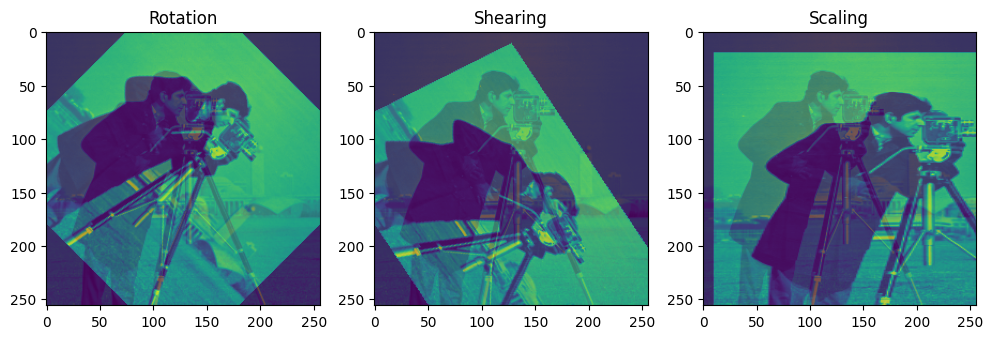

In [4]:
import numpy as np
import sys
sys.path.append('../code')
sys.path.append('../data')

from registration_tests import image_transform_test
image_transform_test()

<div id='ls_overdet_sys_lin_eq'></div>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

### 2.2 Least-squares solution to an overdetermined system of linear equations

A set of linear equations can be written in matrix form in the following way:

\begin{equation*}
\left\{\begin{array}{c}{a_{1,1} w_{1}+a_{1,2} w_{2}+\ldots+a_{1, n} w_{n}=b_{1}} \\ {a_{2,1} w_{1}+a_{2,2} w_{2}+\ldots+a_{2, n} w_{n}=b_{2}} \\ {\vdots} \\ {a_{m, 1} w_{1}+a_{m, 2} w_{2}+\ldots+a_{m, n} w_{n}=b_{m}}\end{array}\right.
\end{equation*}

\begin{equation}
\left[ \begin{array}{cccc}{a_{1,1}} & {a_{1,2}} & {\ldots} & {a_{1, n}} \\ {a_{2,1}} & {a_{2,2}} & {\dots} & {a_{2, n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {a_{m, 1}} & {a_{m, 2}} & {\dots} & {a_{m, n}}\end{array}\right] \left[ \begin{array}{c}{w_{1}} \\ {w_{2}} \\ {\vdots} \\ {w_{n}}\end{array}\right]=\left[ \begin{array}{c}{b_{1}} \\ {b_{2}} \\ {\vdots} \\ {b_{m}}\end{array}\right]
\end{equation}

\begin{equation}
\mathbf{A w}=\mathbf{b}
\end{equation}

where $\mathbf{w}$ is an $n x 1$ column-vector of the unknown variables $w_{i}$, $\mathbf{A}$ is an $m x n$ matrix of the known coefficients and $a_{i, j}$ and $\mathbf{b}$ is an $m x 1$ column-vector of the known constant terms $b_{i}$. Solving the set of equations means finding the values of $w_{i}$ that satisfy the set of equations.

- When $m < n$ the equations have no unique solution.
- When $m = n$ the equations have a unique solution.
- When $m > n$ the equations are overconstrained and there may not be an exact solution for **z**. In this case, what is often consider is minimization of the squared error.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div> 

### *Exercise 2.2.1*:
In `SECTION 2` of the `registration.py` module, `ls_solve()` contains a template for a function that finds the least squares solution for $\mathbf{w}$. Implement the missing functionality of that function.


Test your implementation by solving the following system of equations:

\begin{equation}
\left\{\begin{aligned} 3 w_{1}+4 w_{2} &=1 \\ 5 w_{1}+6 w_{2} &=2 \\ 7 w_{1}+8 w_{2} &=3 \\ 17 w_{1}+10 w_{2} &=4 \end{aligned}\right.
\end{equation}

In order to do so, you have to create the $\mathbf{A}$ matrix and the $\mathbf{B}$ vector in Python and then call the `ls_solve()` function. Implement your code in the `ls_solve_test()` script in the `registration_tests.py` module.

The found solution should be $\mathrm{w}=[0.0694,0.2842]^{\top}$.

In [10]:
%matplotlib inline
import sys
sys.path.append("../code")
from registration_tests import ls_solve_test

ls_solve_test()

w =  [0.06941839 0.28424015]
E =  0.1801125703564728


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div> 

### *Question 2.2.1*:
For which equation does the solution result in the largest error?

<font style="color:red">For the last equation: 17 w1 + 10 w2 = 4</font>

<div id='ls_affine'></div>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

### 2.3 Least-squares fitting of an affine transformation

In point-based image registration, the goal is to find a transformation that aligns the moving with the fixed image given a set of corresponding points in the two images. In the case of affine registration, we make an assumption that the two sets of points are related trough the transformation matrix in the following way:

\begin{equation}
\mathbf{T X}^{\prime}=\mathbf{X}
\end{equation}

\begin{equation}
\left[ \begin{array}{ccc}{w_{1}} & {w_{2}} & {w_{3}} \\ {w_{4}} & {w_{5}} & {w_{6}} \\ {0} & {0} & {1}\end{array}\right] \left[ \begin{array}{cccc}{x_{1}^{\prime}} & {x_{2}^{\prime}} & {\ldots} & {x_{n}^{\prime}} \\ {y_{1}^{\prime}} & {y_{2}^{\prime}} & {\ldots} & {y_{n}^{\prime}} \\ {1} & {1} & {\ldots} & {1}\end{array}\right]=\left[ \begin{array}{cccc}{x_{1}} & {x_{2}} & {\ldots} & {x_{n}} \\ {y_{1}} & {y_{2}} & {\ldots} & {y_{n}} \\ {1} & {1} & {\ldots} & {1}\end{array}\right]
\end{equation}

In the previous expression, $\left\{x_{i}, y_{i}\right\}$ are the coordinates of the points in the fixed image, $\left\{x_{i}^{\prime}, y_{i}^{\prime}\right\}$ are the coordinates of the corresponding points in the moving image and $w_{i}$ are the elements of the transformation matrix (for example, $w_{3}$ and $w_{6}$ are the translation parameters). If we transpose both sides of this equation, it will immediately become obvious that this expression defines two systems of linear equations:

\begin{equation}
\left[ \begin{array}{ccc}{x_{1}^{\prime}} & {y_{1}^{\prime}} & {1} \\ {x_{2}^{\prime}} & {y_{2}^{\prime}} & {1} \\ {\vdots} & {\vdots} & {\vdots} \\ {x_{m}^{\prime}} & {y_{m}^{\prime}} & {1}\end{array}\right] \left[ \begin{array}{ccc}{w_{1}} & {w_{4}} & {0} \\ {w_{2}} & {w_{5}} & {0} \\ {w_{3}} & {w_{6}} & {1}\end{array}\right]=\left[ \begin{array}{ccc}{x_{1}} & {y_{1}} & {1} \\ {x_{2}} & {y_{2}} & {1} \\ {\vdots} & {\vdots} & {\vdots} \\ {x_{m}} & {y_{m}} & {1}\end{array}\right]
\end{equation}

The two systems of equations are:

\begin{equation}
\left[ \begin{array}{ccc}{x_{1}^{\prime}} & {y_{1}^{\prime}} & {1} \\ {x_{2}^{\prime}} & {y_{2}^{\prime}} & {1} \\ {\vdots} & {\vdots} & {\vdots} \\ {x_{m}^{\prime}} & {y_{m}^{\prime}} & {1}\end{array}\right] \left[ \begin{array}{c}{w_{1}} \\ {w_{2}} \\ {w_{3}}\end{array}\right]=\left[ \begin{array}{c}{x_{1}} \\ {x_{2}} \\ {\vdots} \\ {x_{n}}\end{array}\right], \text { and } \left[ \begin{array}{ccc}{x_{1}^{\prime}} & {y_{1}^{\prime}} & {1} \\ {x_{2}^{\prime}} & {y_{2}^{\prime}} & {1} \\ {\vdots} & {\vdots} & {\vdots} \\ {x_{m}^{\prime}} & {y_{m}^{\prime}} & {1}\end{array}\right] \left[ \begin{array}{c}{w_{4}} \\ {w_{5}} \\ {w_{6}}\end{array}\right]=\left[ \begin{array}{c}{y_{1}} \\ {y_{2}} \\ {\vdots} \\ {y_{m}}\end{array}\right]
\end{equation}

The first system gives the solution for $w_{1}$, $w_{2}$ and $w_{3}$. Similarly, the second system gives
the solution for $w_{4}$, $w_{5}$ and $w_{6}$.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div> 

### *Exercise 2.3.1*:
Implement least squares fitting of an affine transform in the provided `ls_affine()` function template in `SECTION 2` of the `registration.py` module. You have to form the $\mathbf{b}$ vector for the two systems of equations. The $\mathbf{A}$ matrix is the same for both systems and already implemented with the line $A = Xm'$. Then call `ls_solve()` to solve the two systems. Finally, you have to use the computed parameters to form a homogeneous transformation matrix (e.g. the first row of the transformation matrix will be the solution for the first linear system of equations). 

Test your implementation by calling `ls_affine_test()` from `SECTION 2` of the `registration_tests.py` module. This function applies some arbitrary affine transformation to a test object, and then transforms the object back to the original with a transformation that is computed with `ls_affine()`. If your implementation is correct the retrieved object should match the original object in the displayed figure.

T= [[  0.76162295   0.4409396  -16.43502156]
 [ -0.8618365    0.74158024  -6.21323986]]


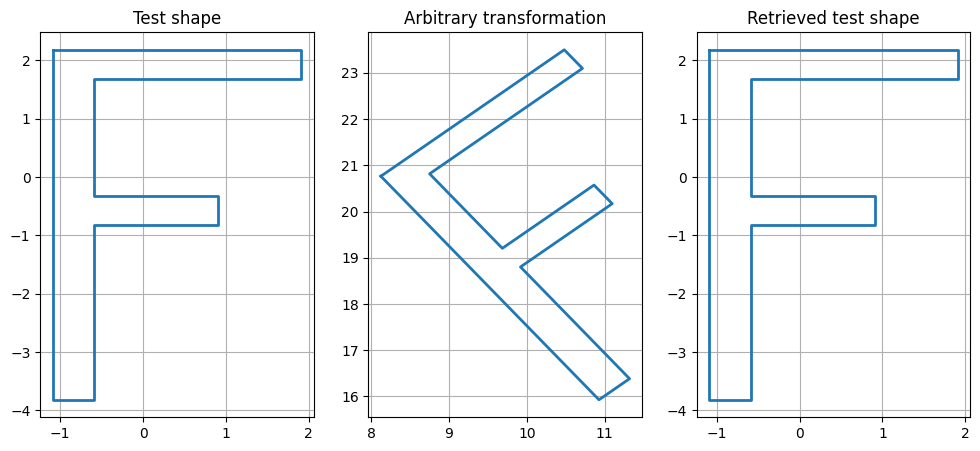

In [32]:
%matplotlib inline
import sys
sys.path.append("../code")
from registration_tests import ls_affine_test

ls_affine_test()